In [ ]:
# error
# transforms.Normalize((0.5,), (0.5,))
# (1, 28, 28)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# transform = simply dictates any image manipulations that you wish to apply on your images
validation_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [4]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

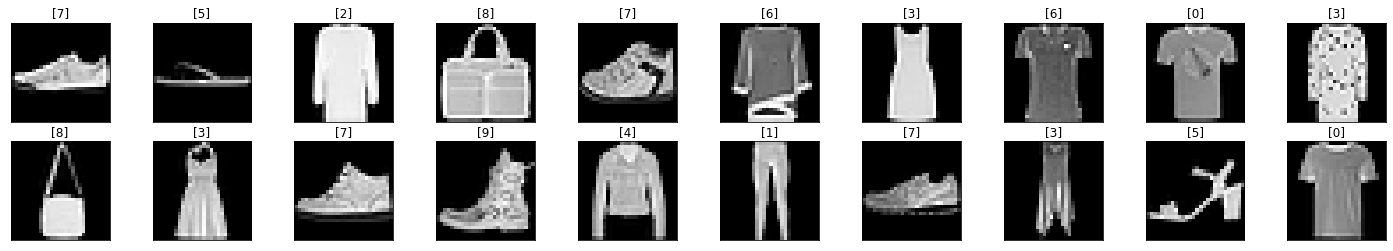

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [6]:
import torch
# torch.nn : 딥러닝 모델에 필요한 모듈이 모여 있는 패키지
import torch.nn as nn

class block(nn.Module):
    # __init__는 클래스 내의 생성자라 불리고 초기화를 위한 함수이다.
    # self는 인스턴스 자신이다.
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        # super(모델명, self).__init__() 형태로 호출
        # 위처럼 호출해서 nn.Module.__init__()을 실행
        super(block, self).__init__()
        self.expansion = 4 # 확장
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 순서로 정의
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        # downsample은 forward시 f(x)+x의 residual을 구현할 경우 f(x)와 x의 텐서사이즈가 다를 때 사용한다.
        self.identity_downsample = identity_downsample
    
    # 네트워크 구조를 정의하는 순방향 함수
    # 여기서는 한가지 입력만 허용하고 있다.
    def forward(self, x):
        # identity에 x 저장
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # x(=출력값)에 identity 값 더함    
        x += identity
        x = self.relu(x)
        return x

In [7]:
class ResNet(nn.Module): # resnet50 : [3, 4, 6, 3]
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        # self._make_layer를 이용하여 residual block들을 쌓는다.
        # 필터의 개수는 각 block들을 거치면서 2배씩 늘어난다. (64->128->256->512)
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # (n, 512, 1, 1)의 텐서로 만든다.
        self.fc = nn.Linear(512*4, num_classes) # fully-connected layer
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # send it into the fully connected layer
        x = self.fc(x)
        return x
    
    # _make_layer에서 residual block 생성
    # block : 앞에 정의한 block 클래스
    # num_residual_blocks : layer 반복해서 쌓는 개수
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        # downsampling이 필요한 경우 identity_downsample 생성
            # 1. stride가 1이 아닐 때
            # 2. self.in_channels가 out_channels*4와 크기가 맞지 않을 때
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4 # 256
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64, 64*4 (256) again
        
        return nn.Sequential(*layers)

In [8]:
def ResNet50(img_channels=1, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels=1, num_classes=10):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels=1, num_classes=10):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

def test():
    net = ResNet101()
    x = torch.randn(2, 1, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)

test()

torch.Size([2, 10])


In [13]:
model = ResNet101()

In [14]:
input = torch.randn((16,1,224,224))
output = model(input)
print(output.shape)

print(model)

# 결과

torch.Size([16, 10])
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, mo

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
epochs = 3
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch : ', (e+1))
        print('training loss: {:.4f}, training acc : {:.4f}'.format(epoch_loss, epoch_acc))
        print('validation loss: {:.4f}, validation acc : {:.4f}'.format(val_epoch_loss, val_epoch_acc))
        

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

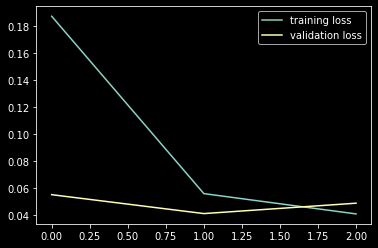

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

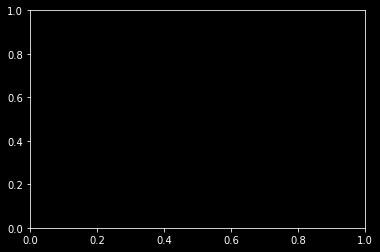

In [ ]:
plt.plot(running_corrects_history, label="training_accuracy")
plt.plot(val_running_corrects_history, label="validation_accuracy")
plt.legend()

<Response [200]>


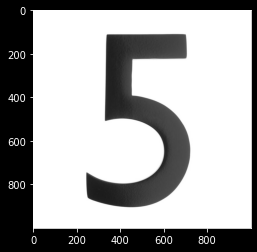

In [ ]:
import requests
from PIL import Image
import PIL
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

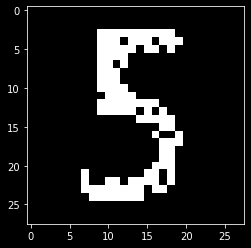

In [ ]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
images = img.to(device)
images =images[0].unsqueeze(0).unsqueeze(0)
output = model(images)
_, pred = torch.max(output, 1)
print(pred.item())

5


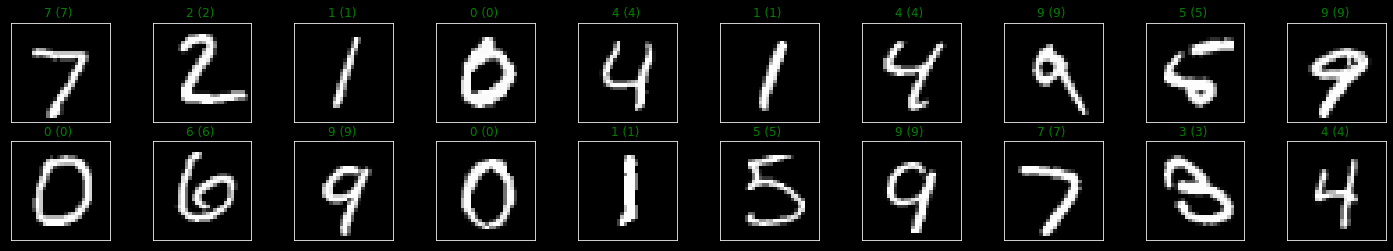

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({}) ".format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx] == labels[idx] else 'red'))